The purpose of this notebook is to explore the classifier results produced by Julian.

Specifically, I'll plot ROC curves and calculate AUCs for each classifier.

Depending on how that goes, I may or may not investigate feature importances for the MS2LDA classifiers.

In [81]:
import pandas as pd
import re
import numpy as np
from scipy import interp

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
resdir = '../../classification_results/'
main = pd.read_csv(resdir + 'main.csv')
main.head()

,ID,Type,C,gamma,n_estimators,max_features,min_samples_leaf,val accuracy,test accuracy,classes,feature importances,feature names
0,1,SVM,215.443469,2.154435e-08,NaN,NaN,NaN,0.662722,0.674556,['Chemical entities' 'Organic compounds'],NaN,NaN
1,2,RF,NaN,NaN,100.0,auto,3.0,0.905325,0.727811,['Chemical entities' 'Organic compounds'],"[ 0. 0. 0. ..., 0. 0. 0.]","['0' '1' '3' ..., '1948' '1961' '1980']"
2,3,SVM,215.443469,2.154435e-08,NaN,NaN,NaN,0.768116,0.666667,['Carbohydrates and carbohydrate conjugates' '...,NaN,NaN
3,4,RF,NaN,NaN,1000.0,auto,2.0,0.971014,0.722222,['Carbohydrates and carbohydrate conjugates' '...,"[ 0. 0. 0. ..., 0. 0. 0.]","['0' '1' '3' ..., '1948' '1961' '1980']"
4,5,SVM,2.154435,1.000000e-05,NaN,NaN,NaN,0.713768,0.294964,['Benzene and substituted derivatives;' 'Benze...,NaN,NaN


# Kingdom-level classifiers

1 = SVM, m/z features   
2 = RF, m/z features   
7 = SVM, ms2lda features   
8 = RF, ms2lda features   

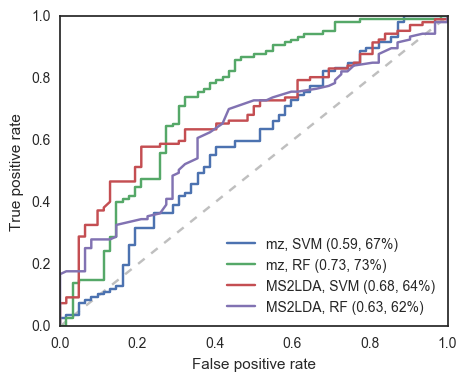

In [170]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(5, 4))

ax.plot([0, 1], [0, 1], c='0.75', linestyle='--')

cls_labels = {1: 'mz, SVM', 2: 'mz, RF', 7: 'MS2LDA, SVM', 8: 'MS2LDA, RF'}
for cls in [1, 2, 7, 8]:
    res = pd.read_csv(resdir + str(cls) + '_test_data.csv', index_col=0)
    
    # Print classes, just to check that "Chemical entities" is indeed the first one in all classifiers
    # We're good!
    #print(main.query('ID == @cls')['classes'])
    
    y_true = res['Label']
    y_probs = res['prob1']

    fpr, tpr, thresholds = roc_curve(y_true, y_probs, pos_label='Chemical entities')
    accuracy = sum(res['Label'] == res['Predicted'])/float(res.shape[0])
    label = cls_labels[cls] + ' ({:.2f}, {:.0f}%)'.format(auc(fpr, tpr), accuracy*100)
    
    ax.plot(fpr, tpr, label=label)
    
plt.legend(loc='lower right')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

In [114]:
cls_labels = {1: 'mz, SVM', 2: 'mz, RF', 7: 'MS2LDA, SVM', 8: 'MS2LDA, RF'}

for cls in [1, 2, 7, 8]:
    print(cls_labels[cls])
    print(np.loadtxt(resdir + str(cls) + '_test_cm.txt'))

mz, SVM
[[ 107.    0.]
 [  55.    7.]]
mz, RF
[[ 99.   8.]
 [ 38.  24.]]
MS2LDA, SVM
[[ 101.    6.]
 [  54.    8.]]
MS2LDA, RF
[[ 88.  19.]
 [ 46.  16.]]


Makes sense that RF works much better than SVM for mz features, and heartening that extracting motifs also helps the classifer (since those features are probably more meaningful than simple m/z).

# Class-classifiers

5 = SVM, mz   
6 = RF, mz   
11 = SVM, ms2lda   
12 = RF, ms2lda   

In [150]:
def return_classes(main, n):
    """
    Parse the string in main['classes'] into a list (gr)
    """
    s = main.query('ID == @n')['classes'].values[0]
    clst = re.split("' '|\n", s.strip('[]'))
    clst = [i.strip("' ") for i in clst]
    return clst

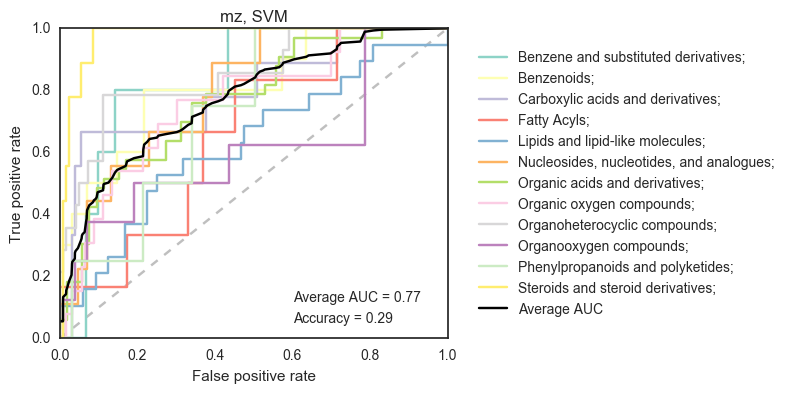

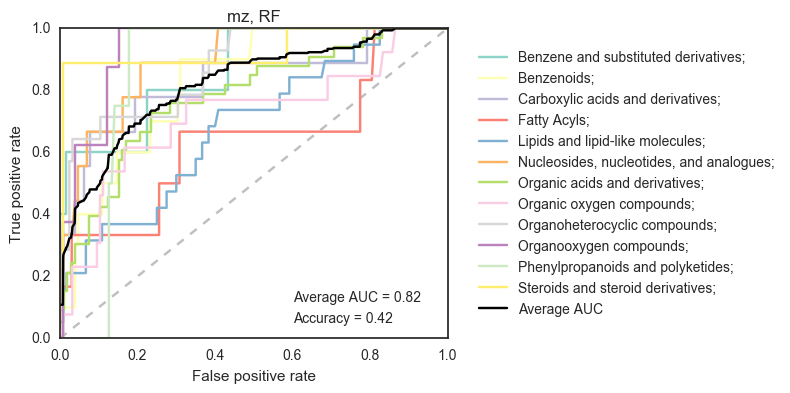

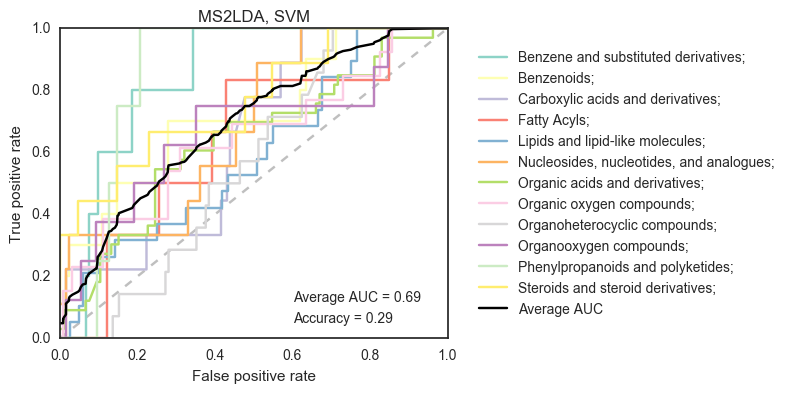

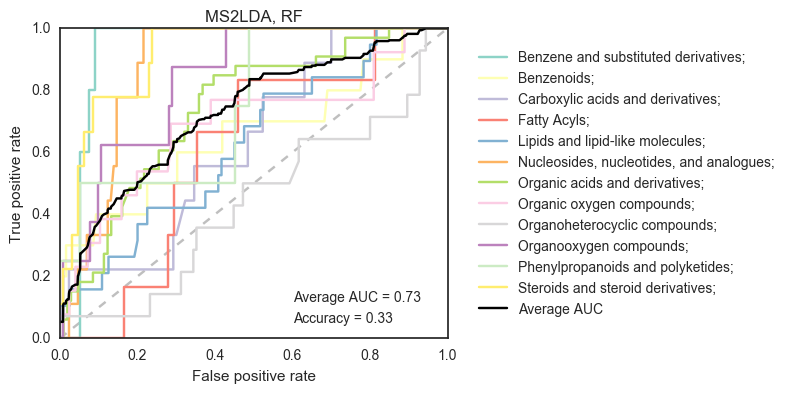

In [161]:
classifier_labels = {5: 'mz, SVM', 6: 'mz, RF', 11: 'MS2LDA, SVM', 12: 'MS2LDA, RF'}
for cls in [5, 6, 11, 12]:

    res = pd.read_csv(resdir + str(cls) + '_test_data.csv', index_col=0)
    # Get the class orders (corresponding to prob1, prob2, etc...)
    labels = return_classes(main, cls)
    #s = main.query('ID == @cls')['classes'].values[0]
    #clst = re.split("' '|\n", s.strip('[]'))
    #labels = [i.strip("' ") for i in slst]
    
    # True labels
    y_true = res['Label']

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    aucs = {}
    for i in range(len(labels)):
        colname = 'prob' + str(i+1)
        probs = res[colname]
        fpr[i], tpr[i], _ = roc_curve(y_true, probs, pos_label=labels[i])
        aucs[i] = auc(fpr[i], tpr[i])

    ## Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(labels)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(labels)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    aucs["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves for each class separately
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot([0, 1], [0, 1], c='0.75', linestyle='--')
    colors = sns.color_palette("Set3", len(labels))
    for i in range(len(labels)):
        ax.plot(fpr[i], tpr[i], c=colors[i], label=labels[i])

    ax.plot(fpr['macro'], tpr['macro'], c='k', label='Average AUC')
    ax.text(0.6, 0.12, 'Average AUC = {:.2f}'.format(auc(fpr['macro'], tpr['macro'])))

    accuracy = sum(res['Label'] == res['Predicted'])/float(res.shape[0])
    ax.text(0.6, 0.05, 'Accuracy = {:.2f}'.format(accuracy))
    
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title(classifier_labels[cls])
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    

# Sub-class

3 = svm, mz   
4 = rf, mz   
9 = svm, lda    
10 = rf, lda   

[[ 0.  3.  0.  0.  0.]
 [ 0.  4.  0.  0.  0.]
 [ 0.  0.  4.  0.  0.]
 [ 0.  3.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.]]
[[ 2.  1.  0.  0.  0.]
 [ 0.  3.  0.  0.  1.]
 [ 0.  0.  4.  0.  0.]
 [ 3.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.]]
[[ 2.  0.  0.  1.  0.]
 [ 2.  1.  0.  1.  0.]
 [ 0.  0.  2.  0.  2.]
 [ 0.  1.  0.  1.  1.]
 [ 2.  2.  0.  0.  0.]]
[[ 3.  0.  0.  0.  0.]
 [ 1.  2.  0.  0.  1.]
 [ 2.  0.  1.  1.  0.]
 [ 0.  0.  1.  0.  2.]
 [ 2.  0.  0.  0.  2.]]


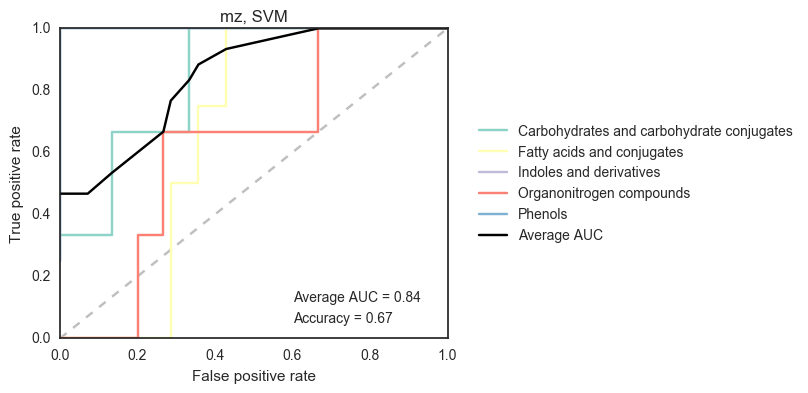

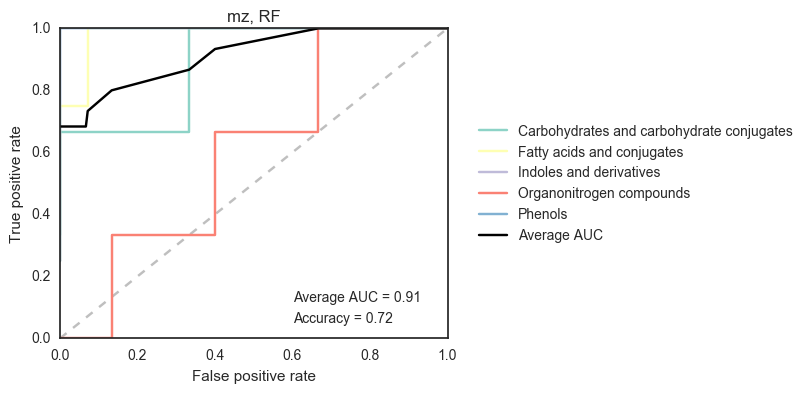

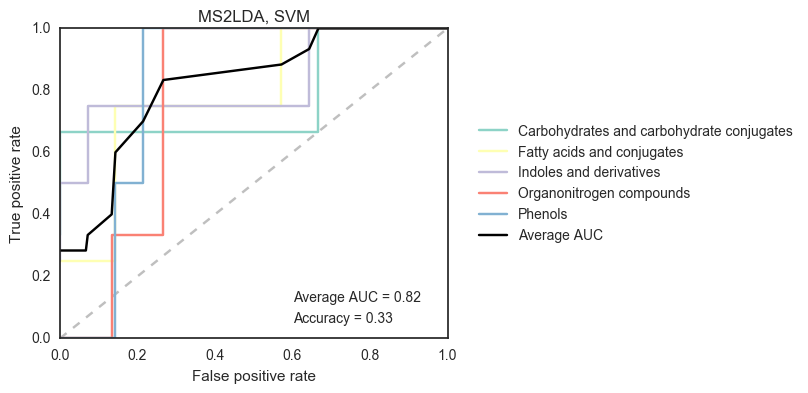

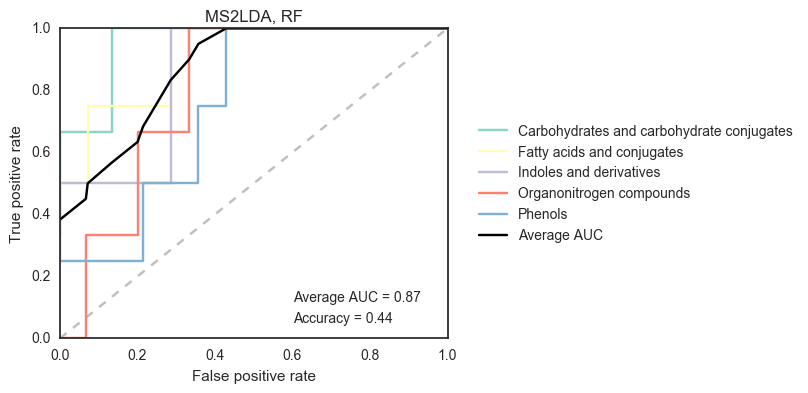

In [175]:
classifier_labels = {3: 'mz, SVM', 4: 'mz, RF', 9: 'MS2LDA, SVM', 10: 'MS2LDA, RF'}

for cls in [3, 4, 9, 10]:
    res = pd.read_csv(resdir + str(cls) + '_test_data.csv', index_col=0)
    # Get the class orders (corresponding to prob1, prob2, etc...)
    labels = return_classes(main, cls)
    #s = main.query('ID == @cls')['classes'].values[0]
    #clst = re.split("' '|\n", s.strip('[]'))
    #labels = [i.strip("' ") for i in slst]

    # True labels
    y_true = res['Label']

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    aucs = {}
    for i in range(len(labels)):
        colname = 'prob' + str(i+1)
        probs = res[colname]
        fpr[i], tpr[i], _ = roc_curve(y_true, probs, pos_label=labels[i])
        aucs[i] = auc(fpr[i], tpr[i])

    ## Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(labels)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(labels)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    aucs["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot ROC curves for each class separately
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot([0, 1], [0, 1], c='0.75', linestyle='--')
    colors = sns.color_palette("Set3", len(labels))
    for i in range(len(labels)):
        ax.plot(fpr[i], tpr[i], c=colors[i], label=labels[i])

    ax.plot(fpr['macro'], tpr['macro'], c='k', label='Average AUC')
    ax.text(0.6, 0.12, 'Average AUC = {:.2f}'.format(auc(fpr['macro'], tpr['macro'])))

    accuracy = sum(res['Label'] == res['Predicted'])/float(res.shape[0])
    ax.text(0.6, 0.05, 'Accuracy = {:.2f}'.format(accuracy))
    
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title(classifier_labels[cls])
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    print(np.loadtxt(resdir + str(cls) + '_test_cm.txt'))

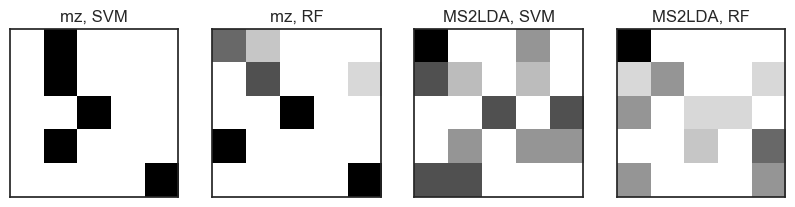

In [194]:
classifier_labels = {3: 'mz, SVM', 4: 'mz, RF', 9: 'MS2LDA, SVM', 10: 'MS2LDA, RF'}

fig, ax = plt.subplots(1, 4, figsize=(10, 4))
ax = ax.flatten()

a = 0
for cls in [3, 4, 9, 10]:
    labels = return_classes(main, cls)
    conf_mat = pd.DataFrame(np.loadtxt(resdir + str(cls) + '_test_cm.txt'),
                           columns=['Pred ' + i for i in labels],
                           index=['True ' + i for i in labels])
    sns.set_style('white')
    #if a == 0:
    #    ax[a].set_yticklabels(conf_mat.index.tolist(), verticalalignment='top')
    ax[a].imshow(conf_mat.divide(conf_mat.sum(axis=1), axis=0), interpolation='nearest')
    ax[a].set_xticklabels('')
    ax[a].set_yticklabels('')
    ax[a].set_title(classifier_labels[cls])
    #ax[i].title("Confusion matrix for class-level. Columns = predicted, rows = true label")
    a += 1

In [191]:
labels

['Carbohydrates and carbohydrate conjugates',
 'Fatty acids and conjugates',
 'Indoles and derivatives',
 'Organonitrogen compounds',
 'Phenols']

In [195]:
cls = 3
np.loadtxt(resdir + str(cls) + '_test_cm.txt')

array([[ 0.,  3.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  0.],
       [ 0.,  0.,  4.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  4.]])